# Hybrid Sampling Techniques
- SMOTE-Tomek
- SMOTE-ENN

In [1]:
import warnings
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')
df_train = pd.read_csv('train.csv')

# Data Pre-processing
df_train['is_anomaly'] = np.where(df_train['is_anomaly'] == False, 0, 1) 
df_train["Is_anomaly"] = df_train['is_anomaly'].values

df_train.drop('is_anomaly', axis = 1 ,inplace = True)

X_train = df_train[['value','predicted']]
y_train = df_train['Is_anomaly']
df_train.head(10)

,timestamp,value,predicted,Is_anomaly
0,1425008573,42,44.072500,0
1,1425008873,41,50.709390,0
2,1425009173,41,81.405120,0
3,1425009473,61,39.950367,0
4,1425009773,44,35.350160,0
5,1425010073,27,27.713638,0
6,1425010373,37,41.545710,0
7,1425010673,36,38.743620,0
8,1425010973,49,40.859787,0
9,1425011273,36,25.444733,0


- Define plot functions 

In [2]:
def plot_resampling(X, y, sampler, ax, title=None):
    X_res, y_res = sampler.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor="k")
    if title is None:
        title = f"Resampling with {sampler.__class__.__name__}"
    ax.set_title(title)
    sns.despine(ax=ax, offset=10)

In [3]:
def plot_decision_function(X, y, clf, ax, title=None):
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step), copy = True
    )

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor="k")
    if title is not None:
        ax.set_title(title)

- Feature Scaling

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

std_scaler = StandardScaler()
mmx_scaler = MinMaxScaler()
rob_scaler = RobustScaler()

# Create scaled datasets 
X_train_S = pd.DataFrame(std_scaler.fit_transform(X_train))
X_train_R = pd.DataFrame(rob_scaler.fit_transform(X_train))
X_train_M = pd.DataFrame(mmx_scaler.fit_transform(X_train))

- SMOTE-Tomek

In [5]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours
from imblearn.combine import SMOTETomek, SMOTEENN

smote_tomek = SMOTETomek(sampling_strategy = 'auto',  smote = SMOTE(sampling_strategy = 0.70), tomek = TomekLinks(), random_state = 99)
smote_enn   = SMOTEENN(sampling_strategy = 'auto', smote = SMOTE(sampling_strategy = 0.70), enn = EditedNearestNeighbours(), random_state=99)

# Fit Hybrid Samplers with different Scaled Features to choose from
# SMOTE-Tomek Over Samplers
X_smote_tomek_S, y_smote_tomek_S = smote_tomek.fit_resample(X_train_S, y_train)
X_smote_tomek_R, y_smote_tomek_R = smote_tomek.fit_resample(X_train_R, y_train)
X_smote_tomek_M, y_smote_tomek_M = smote_tomek.fit_resample(X_train_M, y_train)

# SMOTE-ENN Over Samplers
X_smote_enn_S, y_smote_enn_S = smote_enn.fit_resample(X_train_S, y_train)
X_smote_enn_R, y_smote_enn_R = smote_enn.fit_resample(X_train_R, y_train)
X_smote_enn_M, y_smote_enn_M = smote_enn.fit_resample(X_train_M, y_train)

print('Classes before fit {}'.format(Counter(y_train)))
print('Classes after SMOTE-Tomek fit (Standard Scaling) {}'.format(Counter(y_smote_tomek_S)))
print('Classes after SMOTE-Tomek fit (Robust   Scaling) {}'.format(Counter(y_smote_tomek_R)))
print('Classes after SMOTE-Tomek fit (Min-Max  Scaling) {}'.format(Counter(y_smote_tomek_M)))

print('Classes after SMOTE-ENN  fit (Standard Scaling) {}'.format(Counter(y_smote_enn_S)))
print('Classes after SMOTE-ENN  fit (Robust   Scaling) {}'.format(Counter(y_smote_enn_R)))
print('Classes after SMOTE-ENN  fit (Min-Max  Scaling) {}'.format(Counter(y_smote_enn_M)))

Classes before fit Counter({0: 15054, 1: 776})
Classes after SMOTE-Tomek fit (Standard Scaling) Counter({0: 14785, 1: 10537})
Classes after SMOTE-Tomek fit (Robust   Scaling) Counter({0: 14795, 1: 10537})
Classes after SMOTE-Tomek fit (Min-Max  Scaling) Counter({0: 14787, 1: 10537})
Classes after SMOTE-ENN  fit (Standard Scaling) Counter({0: 13735, 1: 10537})
Classes after SMOTE-ENN  fit (Robust   Scaling) Counter({0: 13798, 1: 10537})
Classes after SMOTE-ENN  fit (Min-Max  Scaling) Counter({0: 13783, 1: 10537})


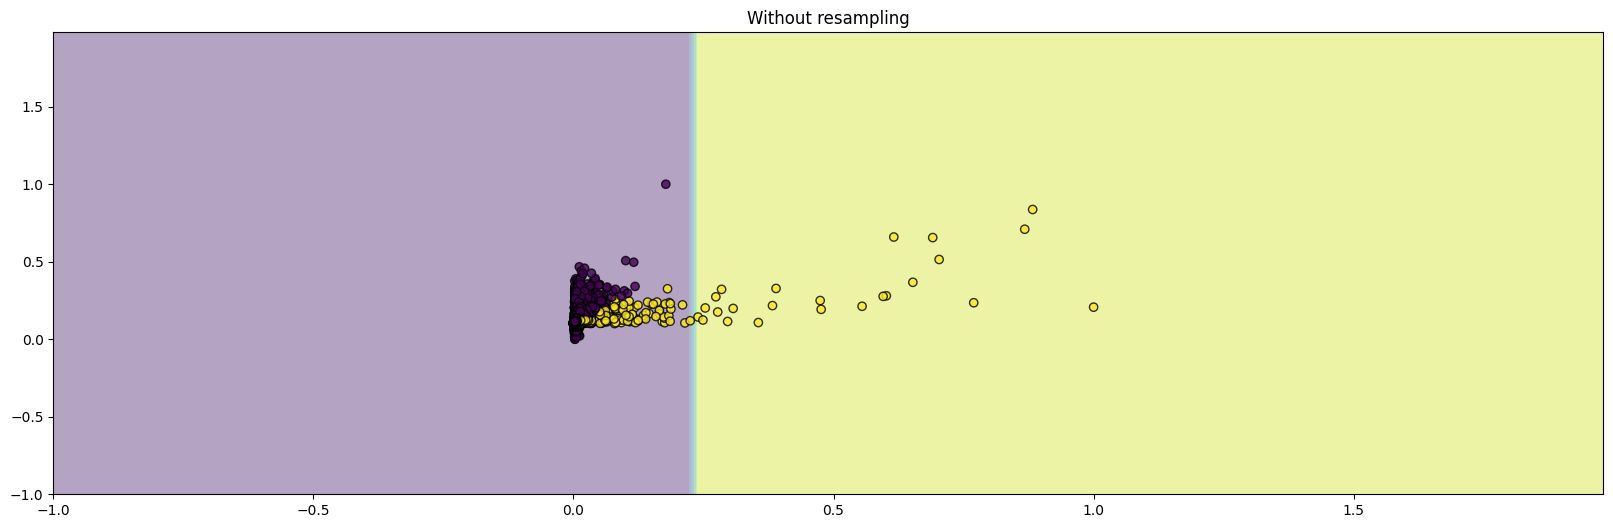

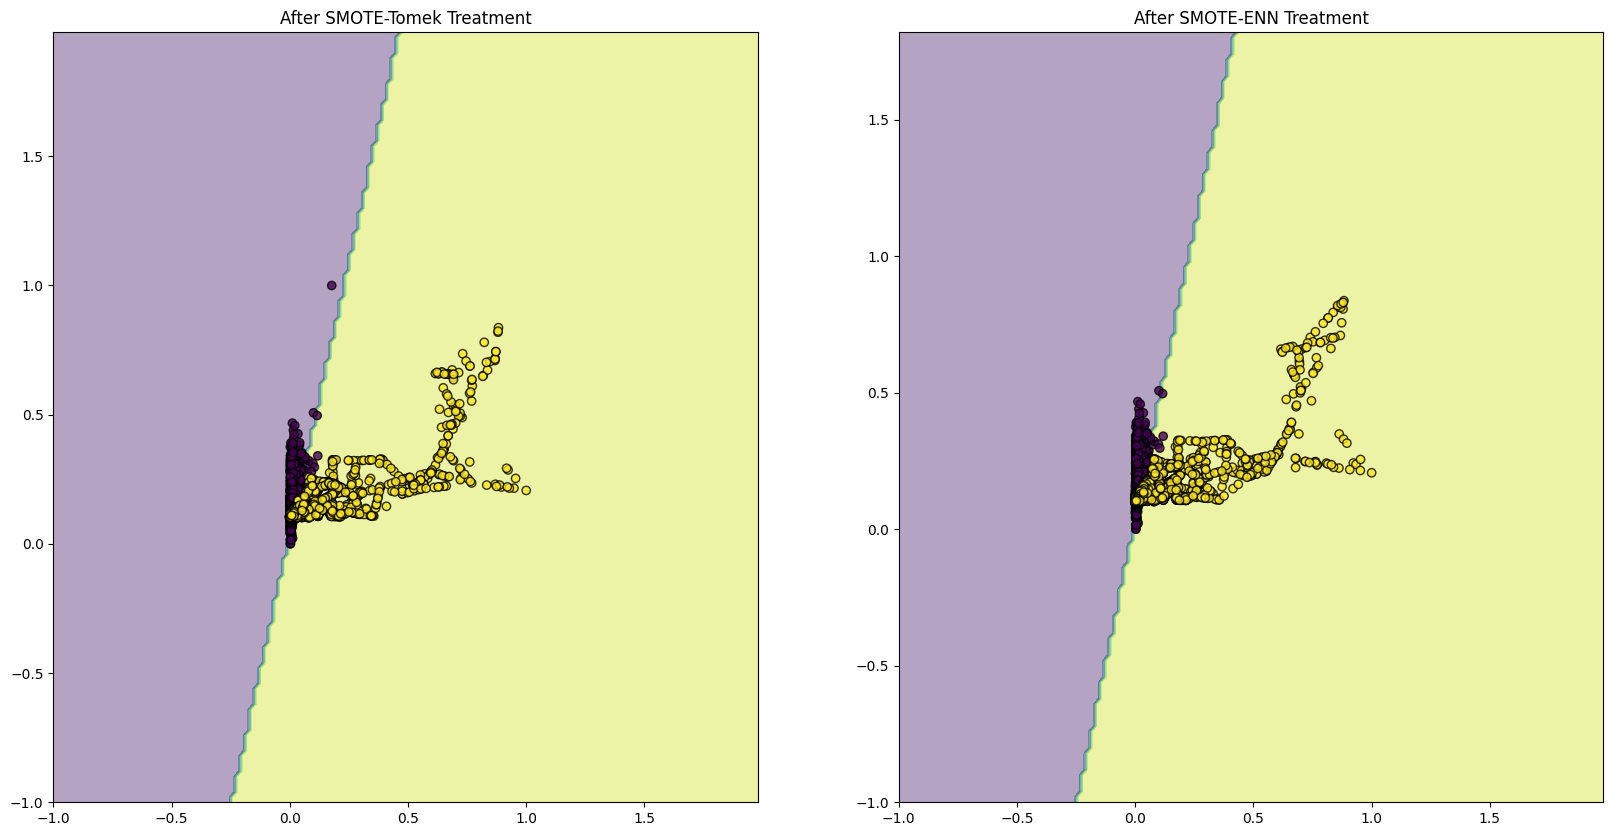

In [6]:
from sklearn.linear_model import LogisticRegression

## Specify model with scaled features
model_Imbalanced = LogisticRegression().fit(X_train_M, y_train)
model_SMOTETOMEK = LogisticRegression().fit(X_smote_tomek_M, y_smote_tomek_M)
model_SMOTE_ENN  = LogisticRegression().fit(X_smote_enn_M, y_smote_enn_M)

fig, ax = plt.subplots( figsize=(20, 6))
plot_decision_function(X_train_M.to_numpy(), y_train.to_numpy(), model_Imbalanced, ax, title="Without resampling")

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
plot_decision_function(X_smote_tomek_M.to_numpy(), y_smote_tomek_M.to_numpy(), model_SMOTETOMEK, axs[0], title="After SMOTE-Tomek Treatment")
plot_decision_function(X_smote_enn_M.to_numpy(), y_smote_enn_M.to_numpy(), model_SMOTE_ENN, axs[1], title="After SMOTE-ENN Treatment")
